# Assignment 1
### Large Scale Data Analysis
Forecasting Wind Power Production in Orkney (Scotland)

In [1]:
# import installation
# installation.install('influxdb')
# installation.install('pandas')
# installation.install('numpy')
# installation.install('matplotlib')
# installation.install('scikit-learn')
# installation.install('tqdm')

import processing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm
from influxdb import InfluxDBClient
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Data Loading & Merging

In [2]:
# Creating the client and switching to the correct database
client = InfluxDBClient(host='influxus.itu.dk', port=8086, 
    username='lsda', password='icanonlyread')
client.switch_database('orkney')

In [3]:
# Get data from last 90 days
generation = client.query(
    "SELECT * FROM Generation WHERE time > now()-90d"
    ) 
wind = client.query(
    "SELECT * FROM MetForecasts WHERE time > now()-90d and time <= now() and Lead_hours = '1'"
    )

In [4]:
gen_df = processing.get_df(generation).drop(['ANM', 'Non-ANM'], axis=1)
wind_df = processing.get_df(wind).drop(['Lead_hours', 'Source_time'], axis=1)

In [5]:
# We merge the dataframes with a tolerance, since the wind df only has entries for every 3 hours
df = pd.merge_asof(gen_df, wind_df, on='time', tolerance=pd.Timedelta('30min'))

df = df.set_index("time")
df.index = pd.to_datetime(df.index).tz_localize(None)

df_wona = df.dropna().copy()

In [6]:
print("The Generation DataFrame has ",gen_df.shape[0], " Entries")
print("The Wind DataFrame has ",wind_df.shape[0], " Entries")
print("\nThe Merged DataFrame has ",df.shape[0], " Entries")
print("The Merged DataFrame wo/'na' has ",df_wona.shape[0], " Entries")

The Generation DataFrame has  129040  Entries
The Wind DataFrame has  717  Entries

The Merged DataFrame has  129040  Entries
The Merged DataFrame wo/'na' has  22186  Entries


## Train - Test Split

In [7]:
### Test split
split_date = np.datetime64('now') - np.timedelta64(20, 'D')
df_wona_train, df_wona_test = df_wona[df_wona.index < split_date].copy(), df_wona[df_wona.index >= split_date].copy()

df_wona_test, test_totals = df_wona_test[['Speed', 'Direction']], df_wona_test['Total']

### Validation split
split_date = np.datetime64('now') - np.timedelta64(22, 'D')
df_wona_train, df_wona_val = df_wona[df_wona.index < split_date].copy(), df_wona[df_wona.index >= split_date].copy()

df_wona_train, train_totals = df_wona_train[['Speed', 'Direction']], df_wona_train['Total']
df_wona_val, val_totals = df_wona_val[['Speed', 'Direction']], df_wona_val['Total']

## Preprocessing

### Handling Categorical Feature 'Direction'
I found the most interesting approach to be handling the wind speed and direction as a combined vector. This takes advantage of knowing the angle and hypoteneus of a triangle to calculate each component (x- & y-coordinate). I still kept the speed in as an attribute.

### Feature Scaling
I scale using a standard scaler, which attempts to give each individual feature mean 0 and unit variance.

### Pipeline

In [8]:
preproces = Pipeline([
    ('Direction Feature Encoding', processing.DirectionTransformer()),
    ('Scaling', StandardScaler())
    ])

In [9]:
df_wona_train = pd.DataFrame(preproces.fit_transform(df_wona_train), columns=['Speed', 'Wind_x', 'Wind_y'])

In [10]:
df_wona_val = pd.DataFrame(preproces.transform(df_wona_val), columns=['Speed', 'Wind_x', 'Wind_y'])

## EDA

### Plotting to gain some insight

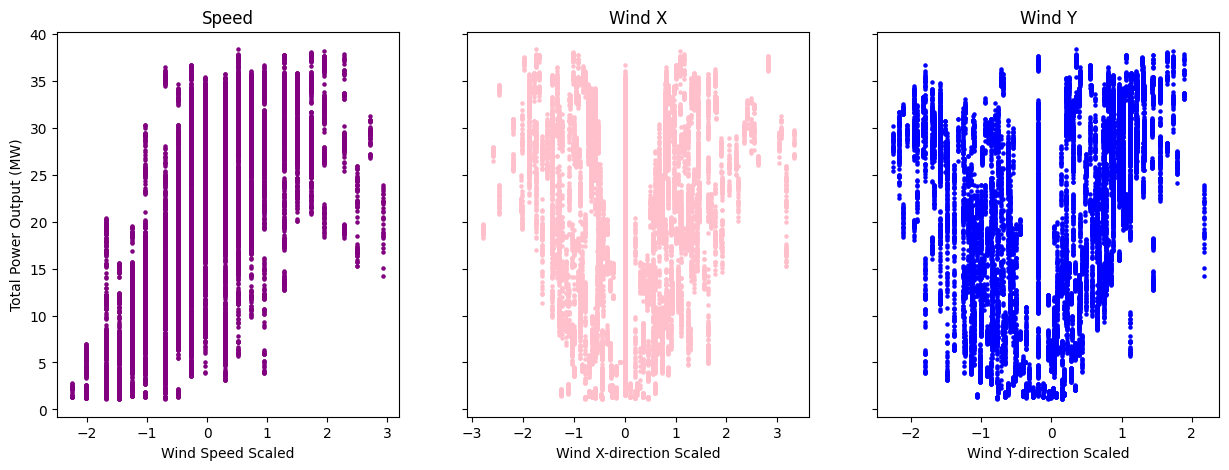

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey='all')

axes[0].scatter(df_wona_train['Speed'], train_totals, s=5, c='Purple')
axes[1].scatter(df_wona_train['Wind_x'], train_totals, s=5, c='Pink')
axes[2].scatter(df_wona_train['Wind_y'], train_totals, s=5, c='Blue')

axes[0].set_title('Speed')
axes[0].set_xlabel('Wind Speed Scaled')
axes[1].set_title('Wind X')
axes[1].set_xlabel('Wind X-direction Scaled')
axes[2].set_title('Wind Y')
axes[2].set_xlabel('Wind Y-direction Scaled')

axes[0].set_ylabel('Total Power Output (MW)');

#fig.savefig('figure1.png')

In [12]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(df_wona_train['Wind_x'], df_wona_train['Wind_y'], train_totals, s=2);

## Machine Learning Algorithm
### Hyper Parameter Tuning

In [13]:
tune_hyper = False
degrees = [1, 2, 3, 4]
min_samples = [1, 5, 10, 20, 40, 80, 160, 320, 500, 1000, 1500, 2000, 2500, 3000, 3500]

In [14]:
if tune_hyper:
    ridge_train = []
    ridge_val = []
    for i in tqdm(degrees):
        ridge_kernel = KernelRidge(kernel='polynomial', degree=i)
        ridge_kernel.fit(df_wona_train, train_totals)
        ridge_train.append(r2_score(train_totals, ridge_kernel.predict(df_wona_train)))
        ridge_val.append(r2_score(val_totals, ridge_kernel.predict(df_wona_val)))

if tune_hyper:    
    tree_train = []
    tree_val = []
    for i in tqdm(min_samples):
        decision_tree = DecisionTreeRegressor(random_state=17, min_samples_leaf=i)
        decision_tree.fit(df_wona_train, train_totals)
        tree_train.append(r2_score(train_totals, decision_tree.predict(df_wona_train)))
        tree_val.append(r2_score(val_totals, decision_tree.predict(df_wona_val)))


In [15]:
if tune_hyper:
    fig, axes = plt.subplots(1,2, sharey=True, figsize=(15,5))
    axes[0].plot(degrees, ridge_train, color='steelblue')
    axes[0].plot(degrees, ridge_val, color='purple')
    axes[0].set_title('Ridge Kernel R2 score')
    axes[0].set_xlabel('Degree of Polynomial Kernel')
    axes[0].grid(which='major', linestyle='-', color='lightsteelblue')
    axes[0].fill_between(degrees, -0.4, ridge_train, alpha=0.2)
    axes[0].fill_between(degrees, -0.4, ridge_val, alpha=0.3, color='purple')

    axes[1].plot(min_samples, tree_train, color='steelblue')
    axes[1].plot(min_samples, tree_val, color='purple')
    axes[1].set_title('Decision Tree R2 score')
    axes[1].set_xlabel('Minimum Samples in Leaf')
    axes[1].grid(which='major', linestyle='-', color='lightsteelblue')
    axes[1].fill_between(min_samples, -0.4, tree_train, alpha=0.2)
    axes[1].fill_between(min_samples, -0.4, tree_val, alpha=0.3, color='purple')

    fig.legend(['Train R2', 'Validation R2'], loc='center right')

    # plt.savefig('figure3.png')

    print('Manually evaluated on 17/02-2023 that optimal parameters are degree=3 (highest) & min samples leaf=320 (elbow)')

### Training on fetched data

In [16]:
linear_clf = LinearRegression()
ridge_kernel = KernelRidge(kernel='polynomial', degree=3)
decision_tree = DecisionTreeRegressor(random_state=17, min_samples_leaf=320)

In [17]:
linear_clf.fit(df_wona_train, train_totals)
ridge_kernel.fit(df_wona_train, train_totals)
decision_tree.fit(df_wona_train, train_totals);

In [18]:
### Performance on Val
print('Linear model MSE on Validation data:', r2_score(train_totals, linear_clf.predict(df_wona_train)))
print('Ridge Kernel model MSE on Validation data:', r2_score(train_totals, ridge_kernel.predict(df_wona_train)))
print('Decision Tree model MSE on Validation data:', r2_score(train_totals, decision_tree.predict(df_wona_train)))

Linear model MSE on Validation data: 0.579986417603372
Ridge Kernel model MSE on Validation data: 0.6662126822960133
Decision Tree model MSE on Validation data: 0.7219619238193637


In [19]:
### Generating Predictions
linear_preds = linear_clf.predict(df_wona_val)
ridge_preds = ridge_kernel.predict(df_wona_val)
tree_preds = decision_tree.predict(df_wona_val)

In [20]:
### Performance on Val
print('Linear model MSE on Validation data:', r2_score(val_totals, linear_preds))
print('Ridge Kernel model MSE on Validation data:', r2_score(val_totals, ridge_preds))
print('Decision Tree model MSE on Validation data:', r2_score(val_totals, tree_preds))

Linear model MSE on Validation data: -0.389818789336287
Ridge Kernel model MSE on Validation data: 0.215696876087344
Decision Tree model MSE on Validation data: 0.08862687084341814


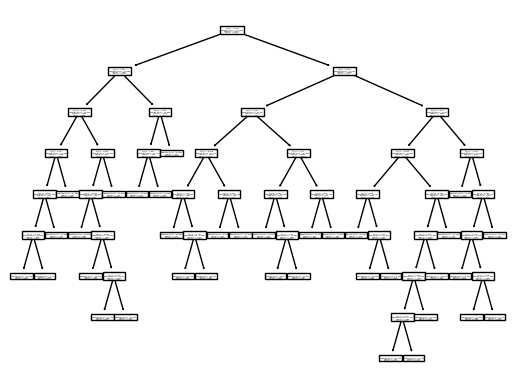

In [21]:
plot_tree(decision_tree);

In [22]:
### this concatenation is done for the sake of below plot; it is sorted due to an easier overview
all_val_preds = pd.DataFrame([np.array(val_totals.reset_index()['Total']), linear_preds, ridge_preds, tree_preds]).transpose().rename(columns={0:'GT', 1:'L', 2:'R', 3:'T'}).sort_values(by='GT', axis=0)

Text(0.5, 1.0, 'Decision Tree')

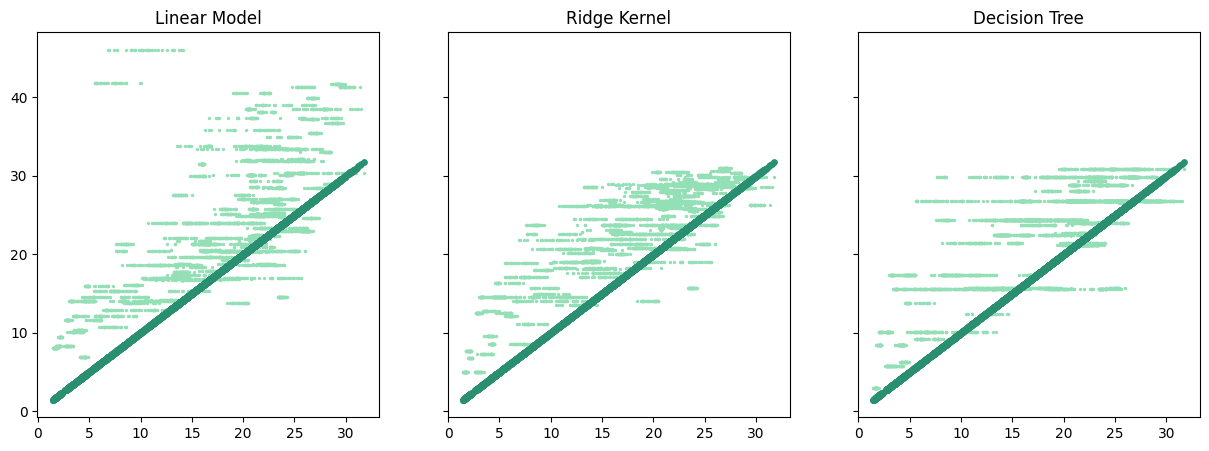

In [23]:
xs = range(all_val_preds.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey='all')

axes[0].scatter(all_val_preds['GT'], all_val_preds['L'], s=2, c="#94e0b6")
axes[0].scatter(all_val_preds['GT'], all_val_preds['GT'], s=15, c="#298f70")
axes[0].set_title('Linear Model')

axes[1].scatter(all_val_preds['GT'], all_val_preds['R'], s=2, c="#94e0b6")
axes[1].scatter(all_val_preds['GT'], all_val_preds['GT'], s=15, c="#298f70")
axes[1].set_title('Ridge Kernel')

axes[2].scatter(all_val_preds['GT'], all_val_preds['T'], s=2, c="#94e0b6")
axes[2].scatter(all_val_preds['GT'], all_val_preds['GT'], s=15, c="#298f70")
axes[2].set_title('Decision Tree')

#plt.savefig('figure2.png')

### Loading Old predictor + comparison

In [24]:
### First, choosing the best model from above using validation data
models = [linear_clf, ridge_kernel, decision_tree]
loss = [r2_score(val_totals, linear_preds), 
    r2_score(val_totals, ridge_preds),
    r2_score(val_totals, tree_preds)]

chosen = models[np.argmax(loss)]

In [25]:
chosen = Pipeline([
    ("preprocessing", preproces),
    ("classifier", chosen)
])

In [26]:
# Loading the old best model
with open('clfs/best_one.pkl', 'rb') as file:
    best = pickle.load(file)

In [27]:
# Getting the loss and making a print out of which is better on the test data!
models = ['SAVED best', 'NEW best']
best_loss = r2_score(test_totals, best.predict(df_wona_test.copy()))
chosen_loss =  r2_score(test_totals, chosen.predict(df_wona_test.copy()))
print(f"The best performing model on the test set is the {models[np.argmax([best_loss, chosen_loss])]} with MSE {max(best_loss, chosen_loss)}");

c:\Users\jonas\Desktop\LSDA\.conda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelRidge was fitted with feature names
  warnings.warn(
c:\Users\jonas\Desktop\LSDA\.conda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelRidge was fitted with feature names
  warnings.warn(


The best performing model on the test set is the SAVED best with MSE 0.1737938107927356


In [28]:
# If the saved best is still better we do nothing, if the new is better than the saved, 
# we want to save the old best with depr. and today's date, and save the new best.
if best_loss >= chosen_loss:
    pass
else:
    with open('clfs/best_one.pkl', 'wb') as file:
        pickle.dump(chosen, file)
    with open(f"clfs/depr_{str(np.datetime64('now', 'h'))}.pkl", 'wb') as file:
        pickle.dump(best, file)

### Forecasting

In [29]:
models = [chosen, best]
forecasting_model = models[np.argmax([best_loss, chosen_loss])]

In [30]:
### Loading data
forecasts = client.query(
    "SELECT * FROM MetForecasts where time > now()"
    )

for_df = processing.get_df(forecasts).drop(['Lead_hours'], axis=1)

In [31]:
newest_source_time = for_df["Source_time"].max()
newest_forecasts = for_df.loc[for_df["Source_time"] == newest_source_time].copy().drop('Source_time', axis=1)

c:\Users\jonas\Desktop\LSDA\.conda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KernelRidge was fitted with feature names
  warnings.warn(


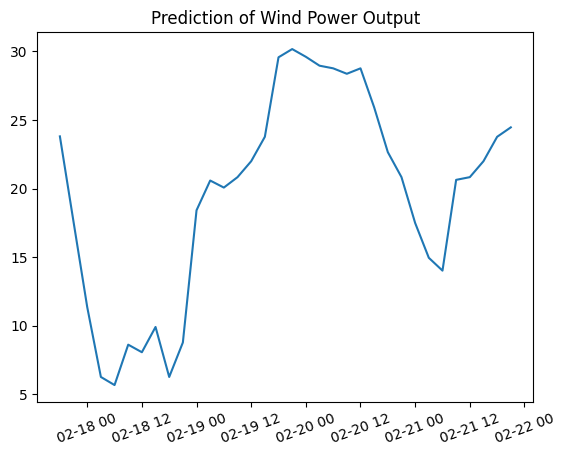

In [32]:
fig, ax = plt.subplots()
ax.plot(newest_forecasts.index, forecasting_model.predict(newest_forecasts))
ax.set_title('Prediction of Wind Power Output')
ax.tick_params(axis='x', labelrotation = 20)
#plt.savefig('figure4.png')